In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import polyan

#define the trace for the experimental profile
exp_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
exp_peaks = exp_peaks/ np.sum(exp_peaks)
x_exp,y_exp = polyan.plot_poly(exp_peaks)

In [2]:
def weighted_rmsd_profile(peakvols1, peakvols2, parset='Scer', weights_vec=[1] ):

    '''Calculates the Root Mean Square Deviation between
    two polysome profiles simulated using polyan.fp2poly().
    This version of the function allows apportioning different 
    weights along the gradient.

    Parameters
    ----------
    peakvols1 : numpy.ndarray
    peakvols2 : numpy.ndarray
        arrays containing peak volumes for two datasets calculated by fp2 poly
    parset : str
        The name of the reference peak volumes to be used if peakvols2 is "ref"
        This parameter is only evaluated if peakvols2 is refseq
    weights_vec: list
        a vector containing relative weights along the profile.
        The default [1] means all values are weighted equally.

    Returns
    -------
    float
        the calculated RMSD between the two peak volume arrays.
    '''

    if type(peakvols2) == str and peakvols2 == 'ref':
        if parset == 'Scer':
            ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012,
                         0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015,
                         0.001, 0.0005, 0.0002, 5e-05]
            peakvols2 = ref_peaks / np.sum(ref_peaks)
        elif parset == 'HEK':
            ref_peaks = [0.0048, 0.008, 0.0033, 0.0019, 0.0032, 0.004, 0.004,
                         0.0032, 0.003, 0.003, 0.00255, 0.00265, 0.002,
                         0.00195, 0.0018, 0.0017, 0.0013, 0.00097, 0.00079,
                         0.00043, 0.00035, 0.00036, 0.00036]
            peakvols2 = ref_peaks / np.sum(ref_peaks)

    # ensure that both peakvols are of equal length - pad with zeros
    if len(peakvols1) < len(peakvols2):
        temp = np.zeros_like(peakvols2)
        temp[:len(peakvols1)] = peakvols1
        peakvols1 = temp.copy()
    elif len(peakvols1) > len(peakvols2):
        temp = np.zeros_like(peakvols1)
        temp[:len(peakvols2)] = peakvols2
        peakvols2 = temp.copy()
    
    weighted_diffs = np.subtract(peakvols1, peakvols2) * weights_vec
        
    rmsd = np.sqrt(sum(np.square(weighted_diffs)) / len(peakvols1))

    return rmsd

<a name='RNA_ref'></a>
<a href='#home'>Return to top</a>
<h2>Effect of RNA-Seq data quality on modelled polysome profiles</h2>

In [3]:
comparisons = [[],[],[]]
weights_vecs = [[1],list(range(0,32,1)),list(range(32,0,-1))]
#process the yeast datasset files
files = list(pd.read_csv('Data/yeast_datasets.csv')['SeriesID'])
for file in files:
    #load data
    dats = pd.read_csv('Data/' + file + '.csv')
    #only process datasets that have accompanying RNA data
    if not 'RNA_Prints' in dats.columns:
        pass
    else:
        #model peak volumes with own and reference RNA data and compare each to experimental profile
        own_rna_peakvols = polyan.fp2poly(dats)
        ref_rna_peakvols = polyan.fp2poly(dats[['ORF','Ribo_Prints']],has_RNA=False)
        for set in range(3):
            comparisons[set].append([file,weighted_rmsd_profile(own_rna_peakvols,exp_peaks,weights_vec=weights_vecs[set]),weighted_rmsd_profile(ref_rna_peakvols,exp_peaks,weights_vec=weights_vecs[set])])
#prepare a colour vector to identify direction of change by colour
cols = []
for n in range(len(comparisons)):
    if comparisons[n][1] > comparisons[n][2]:
        cols.append('green')
    else:
        cols.append('red')
        

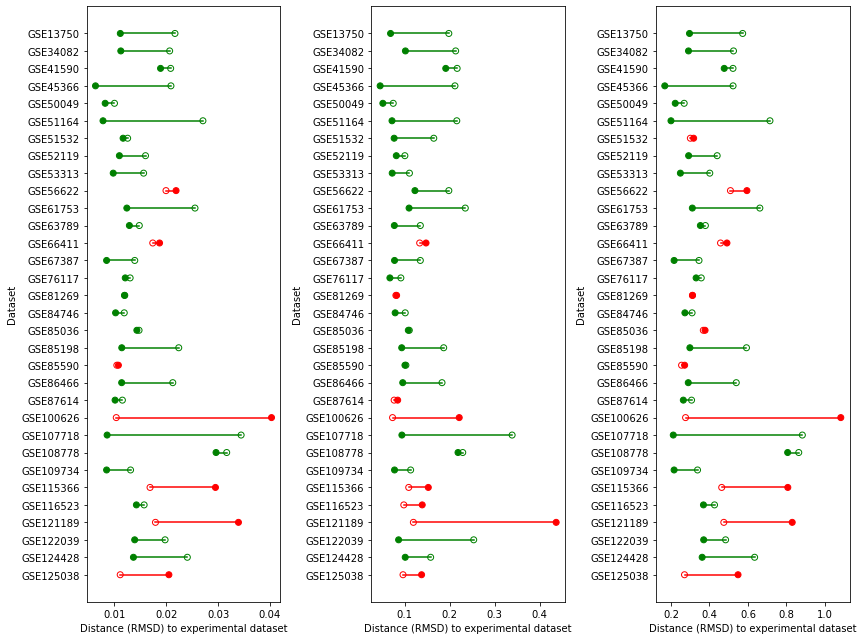

In [4]:
fig,axs = plt.subplots(1,3,figsize=(12,9))
for x in range(3):
    #plot results
    this_comparison = comparisons[x]

    labels, x_own,x_ref = [],[],[]
    for comp in this_comparison:
        labels.append(comp[0])
        x_own.append(comp[1])
        x_ref.append(comp[2])

    #prepare a colour vector to identify direction of change by colour
    cols = []
    for n in range(len(this_comparison)):
        if this_comparison[n][1] > this_comparison[n][2]:
            cols.append('green')
        else:
            cols.append('red')

    #define y coordinates
    ys = [len(this_comparison) - (n + 1) for n in range(len(this_comparison))]

    
    for n in range(len(this_comparison)):
        axs[x].plot((this_comparison[n][1],this_comparison[n][2]),(ys[n],ys[n]),color=cols[n])
    axs[x].scatter(x_own,ys,facecolors = 'white',edgecolors=cols)
    axs[x].scatter(x_ref,ys,c=cols)
    axs[x].set_yticks(ys)
    axs[x].set_yticklabels(labels)
    axs[x].set_xlabel('Distance (RMSD) to experimental dataset')
    axs[x].set_ylabel('Dataset')
plt.savefig('weighted_ref_change.png')
fig.tight_layout()
plt.show()